In [1]:
print("begin import")
import numpy as np
print("numpy done")
import pandas as pd
print("pandas done")
import pickle
print("pickle done, now importing sklearn")
import sklearn
print("sklearn done")


begin import
numpy done
pandas done
pickle done, now importing sklearn
sklearn done


In [2]:
def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
def get_model(filename):
    with open(filename, 'rb') as f:
        mod = pickle.load(f)
    return mod

In [3]:
df = pd.read_csv("combined_data.csv")
model_features = ['comments_disabled', 'ratings_disabled', 'titleLen', 'descriptionLen', 'titleSentiment',
                  'descriptionSentiment', 'titleReadabilityConsensus', 'descriptionReadabilityConsensus',
                  'titleForeignReadability', 'descriptionForeignReadability', 'titleTimeToRead',
                  'descriptionTimeToRead', 'descriptionSyllableCount', 'titleSyllableCount', 'avgTagSentiment',
                  'avgTagReadabilityConsensus', 'avgTagForeignReadability', 'avgTagSyllableCount', 
                  'HoursFromMidnight', 'PublishWeekday', 'PublishMonth', 'numTags', 'CategoryName',
                  'descriptionWordCount', 'titleWordCount']
X = df[model_features]
y = df['isTopViewsPerDay']

In [4]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=2025)

In [5]:
X_train['comments_disabled'] = X_train['comments_disabled'].astype(int)
X_train['ratings_disabled'] = X_train['ratings_disabled'].astype(int)
X_test['comments_disabled'] = X_test['comments_disabled'].astype(int)
X_test['ratings_disabled'] = X_test['ratings_disabled'].astype(int)
categoricals = ['PublishWeekday', 'PublishMonth', 'CategoryName']
for cat in categoricals:
    df_dummies = pd.get_dummies(X_train[cat])
    df_dummies = df_dummies.astype(int)
    X_train = pd.concat([X_train, df_dummies], axis=1) 

    df_dummies = pd.get_dummies(X_test[cat])
    df_dummies = df_dummies.astype(int)
    X_test = pd.concat([X_test, df_dummies], axis=1) 
    
X_train.drop(categoricals, axis=1, inplace=True)
X_test.drop(categoricals, axis=1, inplace=True)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_standardized = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaler = StandardScaler()
X_test_standardized = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [7]:
from sklearn import svm
svmMod = svm.LinearSVC(class_weight={0: 1.0, 1: 6.67}, random_state = 2025, max_iter=10_000)

In [8]:
print("starting")
svmMod.fit(X_train_standardized, y_train)
print("done")

starting
done


In [9]:
save_model(svmMod, "svm.pkl")

In [7]:
svmMod = get_model('svm.pkl')
feature_importances = {}
for i in range(len(X_train.columns)):
    feature_importances[X_train.columns[i]] = (abs(svmMod.coef_[0][i]), (svmMod.coef_[0][i] < 0) )
sorted_importance = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))
sorted_importance    

{'titleLen': (np.float64(1.6016956976641805), np.False_),
 'titleTimeToRead': (np.float64(1.217736251367943), np.True_),
 'descriptionLen': (np.float64(0.9840592926396783), np.False_),
 'descriptionTimeToRead': (np.float64(0.8034359737301052), np.True_),
 'titleWordCount': (np.float64(0.4224472047203316), np.True_),
 'avgTagSyllableCount': (np.float64(0.15604619882306517), np.True_),
 'descriptionWordCount': (np.float64(0.13588700495771003), np.True_),
 'HoursFromMidnight': (np.float64(0.10022814921857198), np.False_),
 'Music': (np.float64(0.06971446744966588), np.False_),
 'People & Blogs': (np.float64(0.06172775941885588), np.True_),
 'Travel & Events': (np.float64(0.061476065887805915), np.True_),
 'Autos & Vehicles': (np.float64(0.06022186763247748), np.True_),
 'Howto & Style': (np.float64(0.05173075468015739), np.True_),
 'avgTagForeignReadability': (np.float64(0.04849870411549989), np.False_),
 'avgTagReadabilityConsensus': (np.float64(0.04795160025473308), np.False_),
 'Friday

In [12]:
from sklearn.metrics import accuracy_score
precisionRecallF1 = sklearn.metrics.precision_recall_fscore_support(y_true=y_test, y_pred=svmMod.predict(X_test_standardized), average='weighted')
print("Accuracy score: ", accuracy_score(y_true=y_test, y_pred=svmMod.predict(X_test_standardized)))
print("Precision: ", precisionRecallF1[0])
print("Recall: ", precisionRecallF1[1])
print("F1 Score: ", precisionRecallF1[2])

Accuracy score:  0.4876343651499232
Precision:  0.8012523563263835
Recall:  0.4876343651499232
F1 Score:  0.5528101691812255


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm


mod = svm.LinearSVC(class_weight={0: 1.0, 1: 6.67}, random_state = 2025)

print("begin")
clf = GridSearchCV(mod, {'max_iter':[250, 500, 1000, 5000, 10_000],
                        'C':[0.01, 0.1, 1.0, 5.0, 10.0]})
clf.fit(X_train_standardized, y_train)
save_model(clf, 'validationSVM.pkl')

begin


In [14]:
clf # best has C = 5.0, max_iter=250

GridSearchCV(estimator=LinearSVC(class_weight={0: 1.0, 1: 6.67},
                                 random_state=2025),
             param_grid={'C': [0.01, 0.1, 1.0, 5.0, 10.0],
                         'max_iter': [250, 500, 1000, 5000, 10000]})

In [39]:
from sklearn.metrics import accuracy_score
clf = get_model('validationSVM.pkl')
precisionRecallF1 = sklearn.metrics.precision_recall_fscore_support(y_true=y_test, y_pred=clf.predict(X_test_standardized), average='weighted')
print("Accuracy score: ", accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_standardized)))
print("Precision: ", precisionRecallF1[0])
print("Recall: ", precisionRecallF1[1])
print("F1 Score: ", precisionRecallF1[2])

Accuracy score:  0.4874727228643013
Precision:  0.8012141771183913
Recall:  0.4874727228643013
F1 Score:  0.5526482643133063


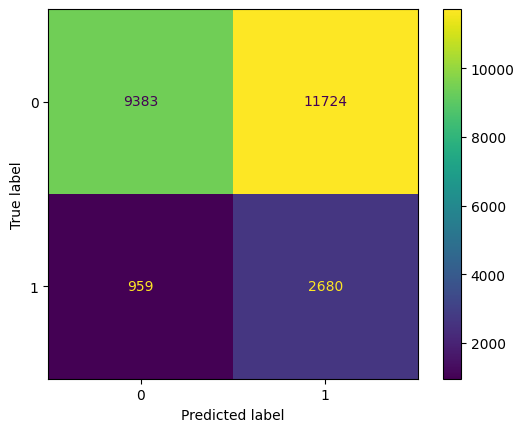

In [16]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=clf.predict(X_test_standardized))

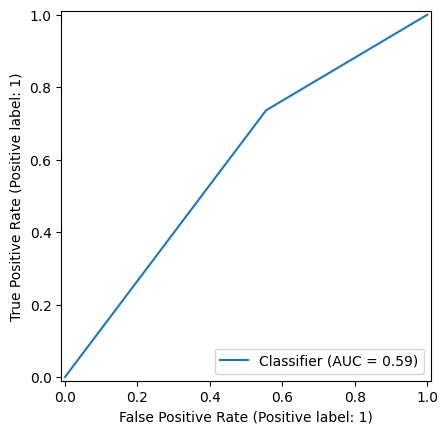

In [41]:
SVM_ROC = sklearn.metrics.RocCurveDisplay.from_predictions(y_true=y_test, y_pred=clf.predict(X_test_standardized))
save_model(SVM_ROC, 'SVM_ROC.pkl')

In [18]:
clf = get_model('validationSVM.pkl')
print("begin")

# This is to generate a learning curve graph
#sklearn.model_selection.learning_curve(clf, X_train, y_train)


begin


In [18]:
lm = sklearn.linear_model.LogisticRegression(solver='sag', class_weight={0: 1.0, 1: 6.67}, random_state = 2025, max_iter=10_000)

In [19]:
print("start")
lm.fit(X_train_standardized, y_train)
print("end")

start
end


In [20]:
save_model(lm, "logisticRegression.pkl")

In [8]:
lm = get_model('logisticRegression.pkl')
feature_importances = {}
for i in range(len(X_train.columns)):
    feature_importances[X_train.columns[i]] = ( abs(lm.coef_[0][i]), (lm.coef_[0][i] < 0) )
sorted_importance = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))
sorted_importance    

{'titleLen': (np.float64(3.35894331972843), np.False_),
 'titleTimeToRead': (np.float64(2.5386616124810155), np.True_),
 'descriptionLen': (np.float64(1.522728282523623), np.False_),
 'descriptionTimeToRead': (np.float64(1.1922929354718768), np.True_),
 'titleWordCount': (np.float64(0.898826084263341), np.True_),
 'avgTagSyllableCount': (np.float64(0.334913620141786), np.True_),
 'HoursFromMidnight': (np.float64(0.21331122517407317), np.False_),
 'descriptionWordCount': (np.float64(0.2103763499465603), np.True_),
 'Music': (np.float64(0.15001047422083605), np.False_),
 'Travel & Events': (np.float64(0.14549558697288423), np.True_),
 'Autos & Vehicles': (np.float64(0.1309118145692861), np.True_),
 'People & Blogs': (np.float64(0.12844154921375125), np.True_),
 'Howto & Style': (np.float64(0.10897955982220989), np.True_),
 'avgTagForeignReadability': (np.float64(0.10415583671282296), np.False_),
 'avgTagReadabilityConsensus': (np.float64(0.10245007745084152), np.False_),
 'Film & Animati

In [22]:
from sklearn.metrics import accuracy_score
precisionRecallF1 = sklearn.metrics.precision_recall_fscore_support(y_true=y_test, y_pred=lm.predict(X_test_standardized), average='weighted')
print("Accuracy score: ", accuracy_score(y_true=y_test, y_pred=lm.predict(X_test_standardized)))
print("Precision: ", precisionRecallF1[0])
print("Recall: ", precisionRecallF1[1])
print("F1 Score: ", precisionRecallF1[2])

Accuracy score:  0.4896953042916027
Precision:  0.8016641383234668
Recall:  0.4896953042916027
F1 Score:  0.5548816694824086


In [24]:
from sklearn.model_selection import GridSearchCV

# TODO: Run this
lm = sklearn.linear_model.LogisticRegression(solver='sag', class_weight={0: 1.0, 1: 6.67}, random_state = 2025)

print("begin")
clf = GridSearchCV(lm, {'max_iter':[250, 500, 1000, 5000, 10_000],
                        'C':[0.01, 0.1, 1.0, 5.0, 10.0]})
clf.fit(X_train_standardized, y_train)
save_model(clf, 'validationLogisticRegr.pkl')

begin


/mnt/c/Users/swats/School/Senior Year (2024-2025)/Spring Semester (2025)/CS 441/CS441 Actual/my-venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/c/Users/swats/School/Senior Year (2024-2025)/Spring Semester (2025)/CS 441/CS441 Actual/my-venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/c/Users/swats/School/Senior Year (2024-2025)/Spring Semester (2025)/CS 441/CS441 Actual/my-venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/c/Users/swats/School/Senior Year (2024-2025)/Spring Semester (2025)/CS 441/CS441 Actual/my-venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reac

In [25]:
clf # best has c = 10, max_iter=10_000

GridSearchCV(estimator=LogisticRegression(class_weight={0: 1.0, 1: 6.67},
                                          random_state=2025, solver='sag'),
             param_grid={'C': [0.01, 0.1, 1.0, 5.0, 10.0],
                         'max_iter': [250, 500, 1000, 5000, 10000]})

In [28]:
feature_importances = {}
for i in range(len(X_train.columns)):
    feature_importances[X_train.columns[i]] = clf.best_estimator_.coef_[0][i]
sorted_importance = dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))
sorted_importance    

{'titleLen': np.float64(3.492026684013921),
 'descriptionLen': np.float64(1.8298032459929336),
 'HoursFromMidnight': np.float64(0.21361023579266236),
 'Music': np.float64(0.14905683939672332),
 'avgTagForeignReadability': np.float64(0.10465998283905911),
 'avgTagReadabilityConsensus': np.float64(0.10289273803397785),
 'Film & Animation': np.float64(0.08393720024028352),
 'numTags': np.float64(0.08382726722580429),
 'Entertainment': np.float64(0.07596990721598369),
 'Science & Technology': np.float64(0.04625933123915189),
 'April': np.float64(0.04483084124683431),
 'Sports': np.float64(0.042984518118906065),
 'Sunday': np.float64(0.042734662230235566),
 'Saturday': np.float64(0.04010960883942229),
 'titleSentiment': np.float64(0.026123867776953802),
 'descriptionReadabilityConsensus': np.float64(0.025216273682458924),
 'October': np.float64(0.022387320584722366),
 'Nonprofits & Activism': np.float64(0.021767226876733454),
 'November': np.float64(0.01754650857409181),
 'September': np.fl

In [7]:
lm = get_model('validationLogisticRegr.pkl')
from sklearn.metrics import accuracy_score
precisionRecallF1 = sklearn.metrics.precision_recall_fscore_support(y_true=y_test, y_pred=lm.predict(X_test_standardized), average='weighted')
print("Accuracy score: ", accuracy_score(y_true=y_test, y_pred=lm.predict(X_test_standardized)))
print("Precision: ", precisionRecallF1[0])
print("Recall: ", precisionRecallF1[1])
print("F1 Score: ", precisionRecallF1[2])

Accuracy score:  0.490058999434252
Precision:  0.801456627359567
Recall:  0.490058999434252
F1 Score:  0.5552855326281088


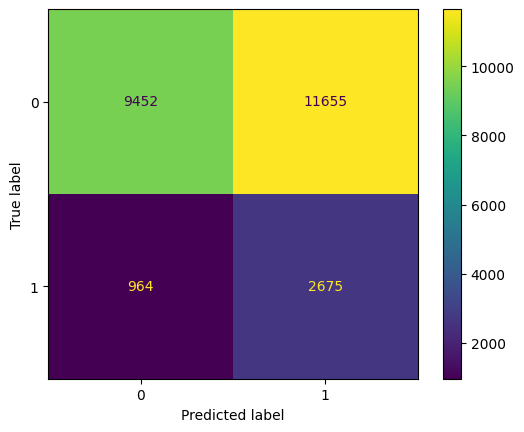

In [35]:
                                                                            #clf.best_estimator_.predict gives same output
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=clf.predict(X_test_standardized))

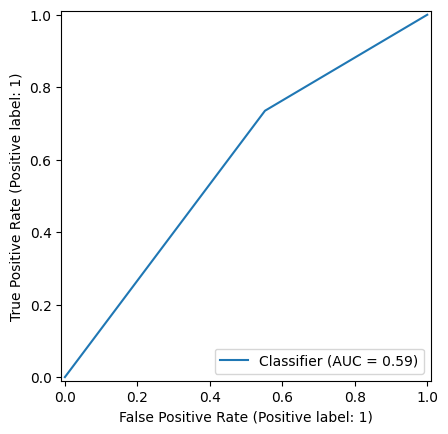

In [37]:
logisticRegressionROC = sklearn.metrics.RocCurveDisplay.from_predictions(y_true=y_test, y_pred=clf.predict(X_test_standardized))
save_model(logisticRegressionROC, 'logisticRegressionROC.pkl')

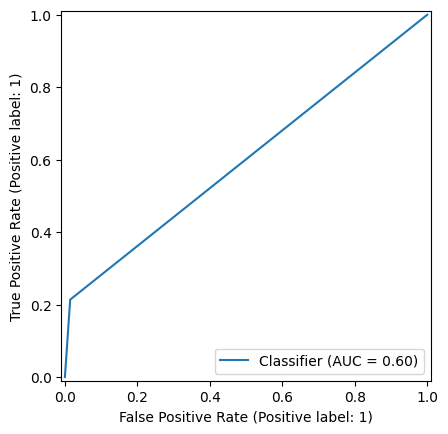

In [45]:
gradBoostROC = get_model('gradBoostROC.pkl')

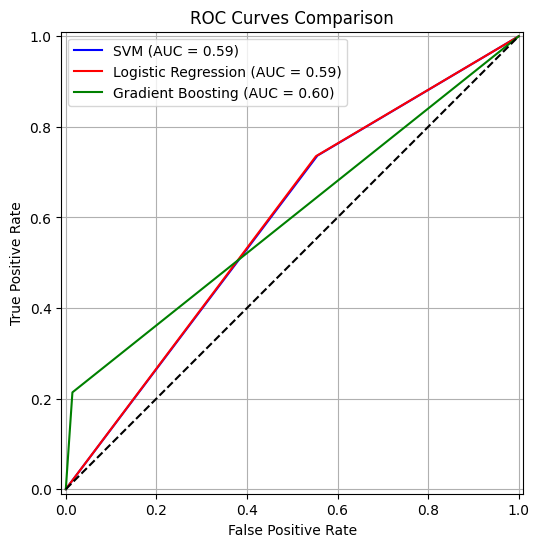

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay




plt.figure(figsize=(8, 6))


roc1 = RocCurveDisplay.from_predictions(y_test, get_model('validationSVM.pkl').predict(X_test_standardized), 
                                       name='SVM',
                                       color='blue',
                                       ax=plt.gca())

roc2 = RocCurveDisplay.from_predictions(y_test, get_model('validationLogisticRegr.pkl').predict(X_test_standardized),
                                       name='Logistic Regression',
                                       color='red',
                                       ax=plt.gca())

roc3 = RocCurveDisplay.from_predictions(y_test, get_model('GradientBoostingAfterValidation.pkl').predict(X_test),
                                       name='Gradient Boosting',
                                       color='green',
                                       ax=plt.gca())

# Customize the plot
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()